In [1]:
import numpy as np
import cv2  # импортирую ИСКЛЮЧИТЕЛЬНО для проверки правильно написанных мною функций

from time import time

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

## Реализация медианного фильтра

### Метод 1. В лоб

In [2]:
def simple_median_filter(img, kernel_size=5, pad=True, true_sort=False):
    assert kernel_size > 0 and kernel_size % 2 == 1
    H, W = img.shape[:2]
    C = img.shape[-1] if len(img.shape) == 3 else 1
    img = img.reshape(H, W, C)
    
    if pad:
        img = np.pad(img, ((kernel_size // 2, kernel_size // 2), (kernel_size // 2, kernel_size // 2), (0, 0)), 'constant', constant_values=0)
    
    H, W, C = img.shape
    result_shape = (H - kernel_size + 1, W - kernel_size + 1, C)
    result = np.zeros(result_shape)
    
    for h in range(result.shape[0]):
        for w in range(result.shape[1]):
            if true_sort:
                result[h, w] = np.sort(img[h:h+kernel_size, w:w+kernel_size].reshape((-1, C)), axis=0)[kernel_size ** 2 // 2 + 1]
            else:
                result[h, w] = np.median(img[h:h+kernel_size, w:w+kernel_size], axis=(0, 1))
            
    return result.astype(np.uint8).squeeze()

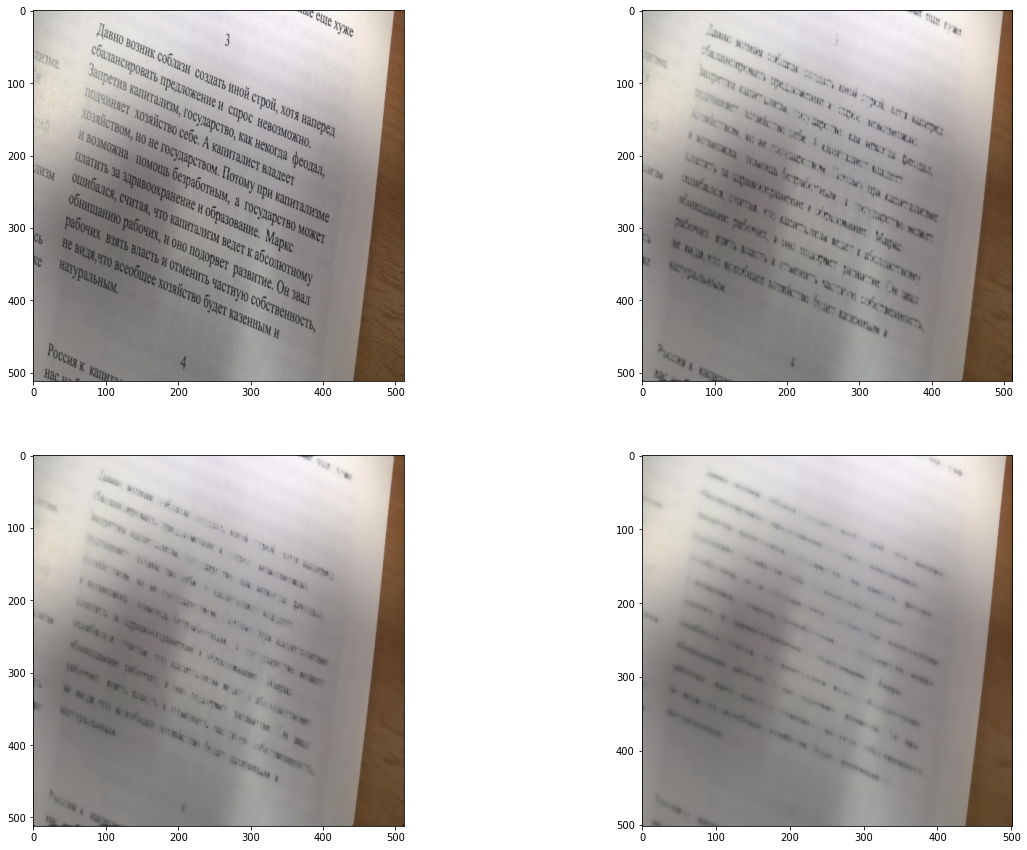

CPU times: user 17.3 s, sys: 336 ms, total: 17.6 s
Wall time: 17.2 s


In [3]:
%%time
img = plt.imread("images/1.jpg")
img = cv2.resize(img, (512, 512))
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.subplot(2, 2, 2)
plt.imshow(simple_median_filter(img))
plt.subplot(2, 2, 3)
plt.imshow(simple_median_filter(img, kernel_size=7, true_sort=True))
plt.subplot(2, 2, 4)
plt.imshow(simple_median_filter(img, kernel_size=11, pad=False))
plt.show()

### Метод 2. Huang c квантизацией (O(R + N))

In [4]:
def huang_median_filter(img, kernel_size=5, pad=True, n_bins=None):
    assert kernel_size > 0 and kernel_size % 2 == 1
    H, W = img.shape[:2]
    C = img.shape[-1] if len(img.shape) == 3 else 1
    img = img.reshape(H, W, C)
    img = img / 255
    
    if pad:
        img = np.pad(img, ((kernel_size // 2, kernel_size // 2), (kernel_size // 2, kernel_size // 2), (0, 0)), 'constant', constant_values=0)
    
    H, W, C = img.shape
    result_shape = (H - kernel_size + 1, W - kernel_size + 1, C)
    result = np.zeros(result_shape)
    
    if n_bins is None:
        n_bins = 2 * kernel_size
    bins = np.linspace(0, 1, n_bins + 1)
    half = kernel_size ** 2 // 2
    
    for c in range(C):
        for h in range(result.shape[0]):
            cnt_cumsum = np.cumsum(np.histogram(img[h:h+kernel_size, :kernel_size, c], bins=bins)[0])
            for w in range(result.shape[1]):
                if w:
                    cnt_cumsum -= np.cumsum(np.histogram(img[h:h+kernel_size, w-1, c], bins=bins)[0])
                    cnt_cumsum += np.cumsum(np.histogram(img[h:h+kernel_size, w+kernel_size-1, c], bins=bins)[0])
                
                median_bin = np.searchsorted(cnt_cumsum, half, side='right')
                result[h, w, c] = (2 * median_bin + 1) / (2 * n_bins)
            
    return (result * 255).astype(np.uint8).squeeze()

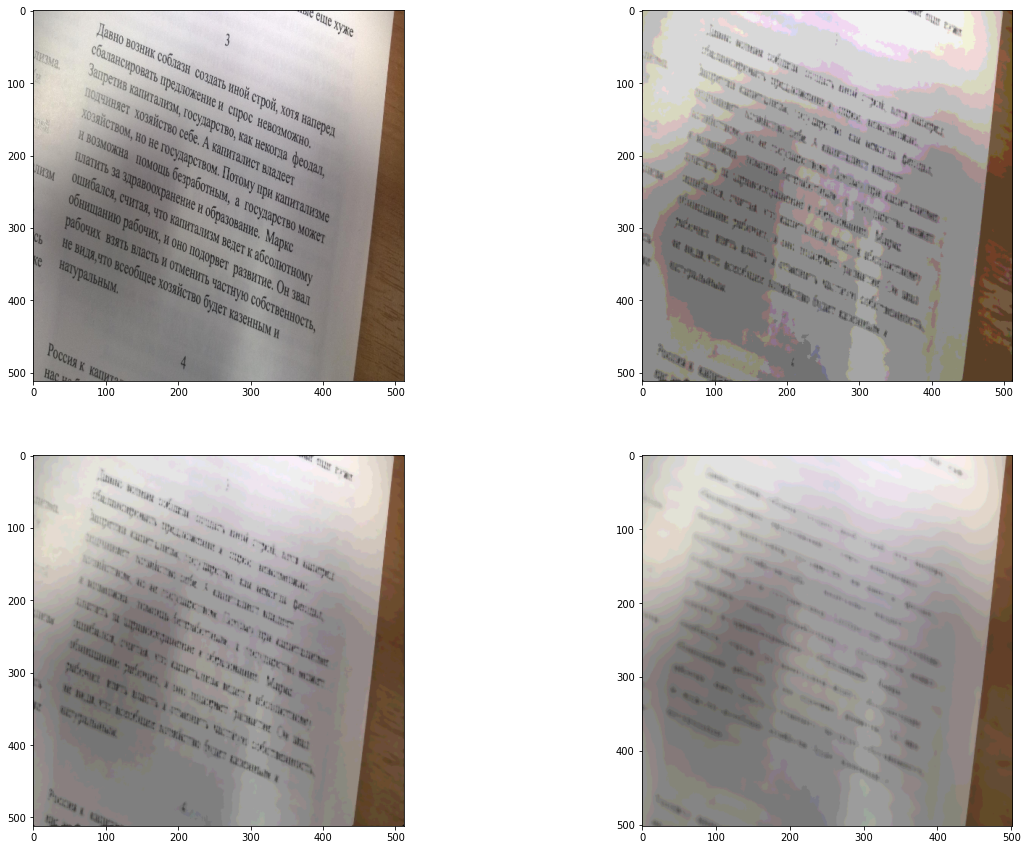

CPU times: user 2min 9s, sys: 3.08 s, total: 2min 12s
Wall time: 2min 8s


In [5]:
%%time
img = plt.imread("images/1.jpg")
img = cv2.resize(img, (512, 512))
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.subplot(2, 2, 2)
plt.imshow(huang_median_filter(img))
plt.subplot(2, 2, 3)
plt.imshow(huang_median_filter(img, n_bins=25))
plt.subplot(2, 2, 4)
plt.imshow(huang_median_filter(img, kernel_size=11, pad=False))
plt.show()

### Метод 3. Perreault (O(1))

In [6]:
def fast_median_filter(img, kernel_size=5, pad=True, n_bins=None):
    assert kernel_size > 0 and kernel_size % 2 == 1
    H, W = img.shape[:2]
    C = img.shape[-1] if len(img.shape) == 3 else 1
    img = img.reshape(H, W, C)
    img = img / 255
    
    if pad:
        img = np.pad(img, ((kernel_size // 2, kernel_size // 2), (kernel_size // 2, kernel_size // 2), (0, 0)), 'constant', constant_values=0)
    
    H, W, C = img.shape
    result_shape = (H - kernel_size + 1, W - kernel_size + 1, C)
    result = np.zeros(result_shape)
    
    if n_bins is None:
        n_bins = 2 * kernel_size
    bins = np.linspace(0, 1, n_bins + 1)
    half = kernel_size ** 2 // 2
    
    for c in range(C):
        column_cnt_cumsums = np.zeros((W, n_bins))
        for w in range(W):
            column_cnt_cumsums[w] = np.cumsum(
                np.histogram(img[:kernel_size, w, c], bins=bins)[0],
            )
        
        for h in range(result.shape[0]):
            if h:
                last_bins = (img[h - 1, :, c] * n_bins).astype(np.int32)
                new_bins = (img[h + kernel_size - 1, :, c] * n_bins).astype(np.int32)
                for w in range(W):
                    column_cnt_cumsums[w, last_bins[w]:] -= 1
                    column_cnt_cumsums[w, new_bins[w]:] += 1
                
            cnt_cumsum = column_cnt_cumsums[:kernel_size].sum(axis=0)
            
            for w in range(result.shape[1]):
                if w:
                    cnt_cumsum -= column_cnt_cumsums[w - 1]
                    cnt_cumsum += column_cnt_cumsums[w + kernel_size - 1]
                
                median_bin = np.searchsorted(cnt_cumsum, half, side='right')
                result[h, w, c] = (2 * median_bin + 1) / (2 * n_bins)
            
    return (result * 255).astype(np.uint8).squeeze()

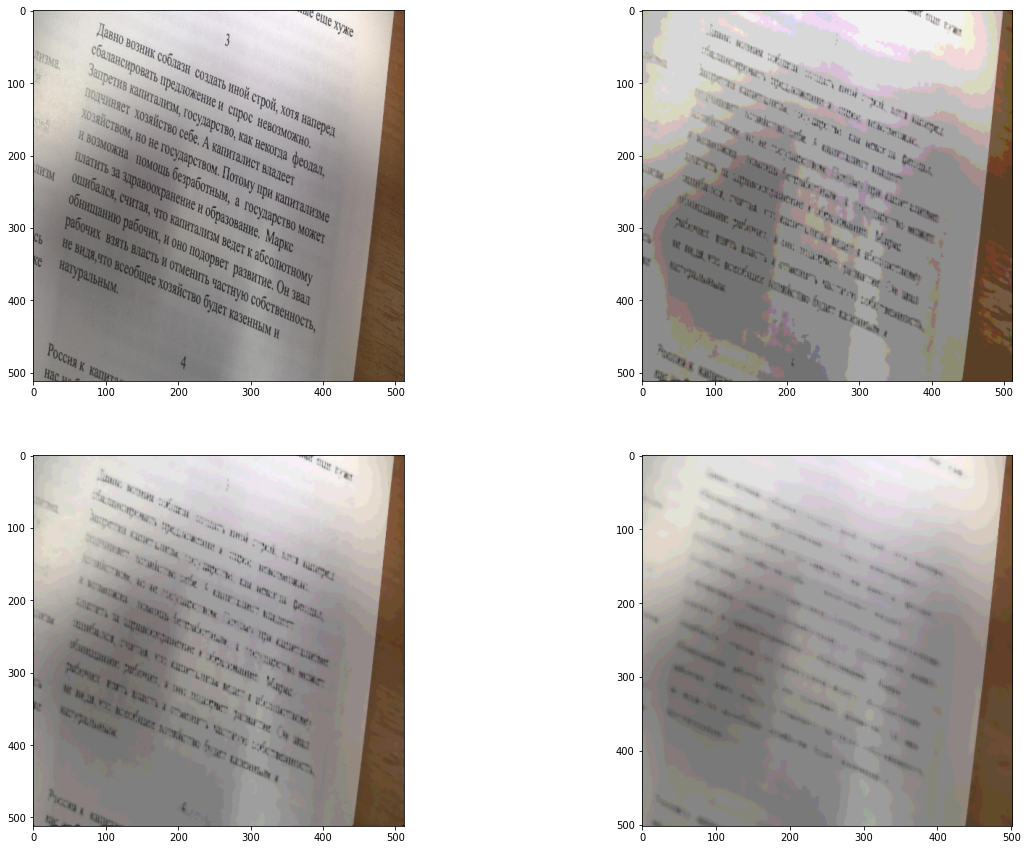

CPU times: user 26.3 s, sys: 4.92 s, total: 31.2 s
Wall time: 25.1 s


In [7]:
%%time
img = plt.imread("images/1.jpg")
img = cv2.resize(img, (512, 512))
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.subplot(2, 2, 2)
plt.imshow(fast_median_filter(img))
plt.subplot(2, 2, 3)
plt.imshow(fast_median_filter(img, n_bins=25))
plt.subplot(2, 2, 4)
plt.imshow(fast_median_filter(img, kernel_size=11, pad=False))
plt.show()

## Сравнение методов

Чтобы было быстрее и понятнее, сначала возьмем уменьшенное изображение 256х256

#### Эксперимент 

Для разные значений `kernel_size`, зафиксированного `pad=True` и разными значениями числа бинов в гистограмме для быстрых алгоритмов

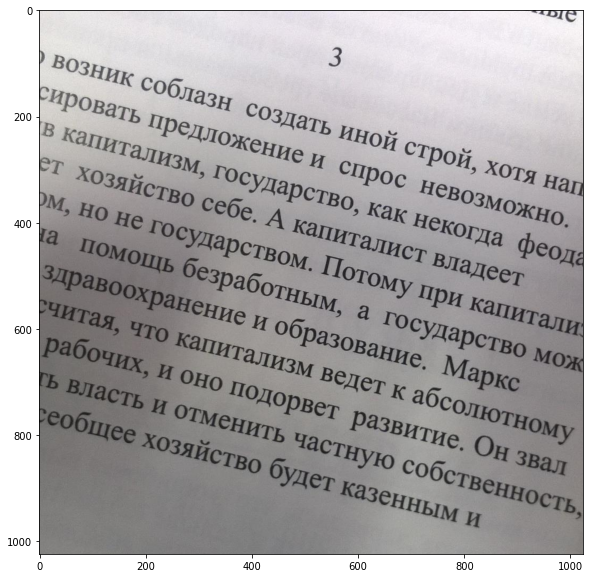

In [8]:
img = plt.imread("images/1.jpg")
img = img[:1024, (img.shape[1] - 1024)//2:(img.shape[1] + 1024)//2]
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

In [9]:
def set_experiment(img):
    results = {
        "cv2":[],
        "simple":[],
        "huang":[],
        "huang_bins16":[],
        "huang_bins64":[],
        "huang_bins256":[],
        "fast":[],
        "fast_bins16":[],
        "fast_bins64":[],
        "fast_bins256":[],
    }

    for kernel_size in tqdm(np.arange(5, 96, 10)):
        # алгоритм библиотеки OpenCV
        start = time()
        cv2.medianBlur(img, kernel_size)
        results["cv2"].append(time() - start)


        # простой алгоритм
        start = time()
        simple_median_filter(img, kernel_size=kernel_size)
        results["simple"].append(time() - start)


        # первый алгоритм с гистограммами
        start = time()
        huang_median_filter(img, kernel_size=kernel_size, n_bins=None)
        results["huang"].append(time() - start)

        start = time()
        huang_median_filter(img, kernel_size=kernel_size, n_bins=16)
        results["huang_bins16"].append(time() - start)

        start = time()
        huang_median_filter(img, kernel_size=kernel_size, n_bins=32)
        results["huang_bins64"].append(time() - start)

        start = time()
        huang_median_filter(img, kernel_size=kernel_size, n_bins=256)
        results["huang_bins256"].append(time() - start)


        # ускоренный алгоритм с гистограммами
        start = time()
        fast_median_filter(img, kernel_size=kernel_size, n_bins=None)
        results["fast"].append(time() - start)

        start = time()
        fast_median_filter(img, kernel_size=kernel_size, n_bins=16)
        results["fast_bins16"].append(time() - start)

        start = time()
        fast_median_filter(img, kernel_size=kernel_size, n_bins=64)
        results["fast_bins64"].append(time() - start)

        start = time()
        fast_median_filter(img, kernel_size=kernel_size, n_bins=256)
        results["fast_bins256"].append(time() - start)
        
    max_time = np.array([values for values in results.values()]).max() * 1.1
    
    grid = np.arange(5, 96, 10)
    colors = ['k', 'r', 'g', 'b']

    plt.figure(figsize=(20, 4))

    plt.subplot(1, 3, 1)
    for label, color in zip(["cv2", "simple", "huang", "fast"], colors):
        plt.plot(grid, results[label], color=color, label=label)
    plt.legend()
    plt.grid()
    plt.ylim(0, max_time)

    plt.subplot(1, 3, 2)
    for label, color in zip(["huang", "huang_bins16", "huang_bins64", "huang_bins256"], colors):
        plt.plot(grid, results[label], color=color, label=label)
    plt.legend()
    plt.grid()
    plt.ylim(0, max_time)

    plt.subplot(1, 3, 3)
    for label, color in zip(["fast", "fast_bins16", "fast_bins64", "fast_bins256"], colors):
        plt.plot(grid, results[label], color=color, label=label)
    plt.legend()
    plt.grid()
    plt.ylim(0, max_time)

    plt.show()
    
    return results

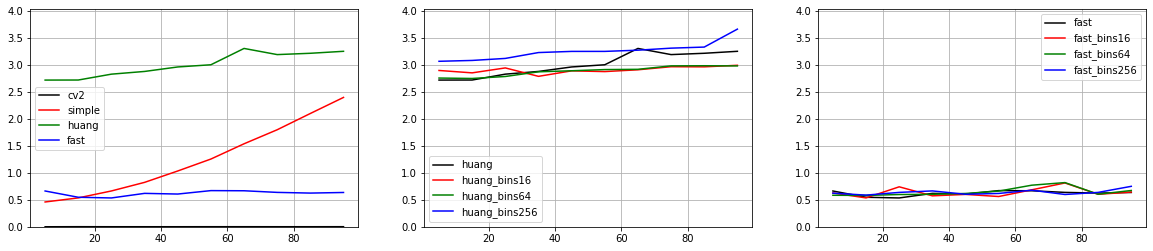

In [10]:
results_128 = set_experiment(cv2.resize(img, (128, 128)))

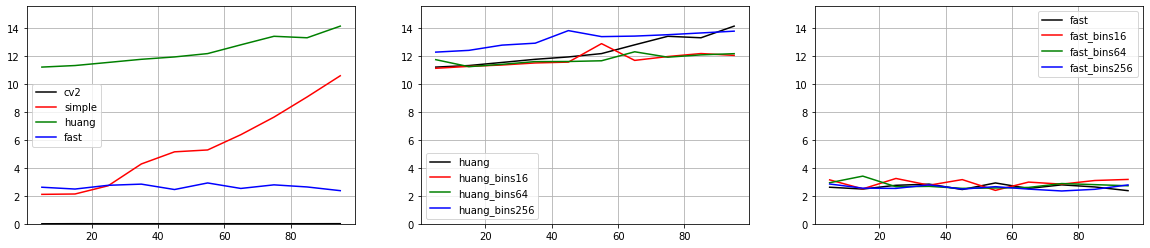

In [11]:
results_256 = set_experiment(cv2.resize(img, (256, 256)))

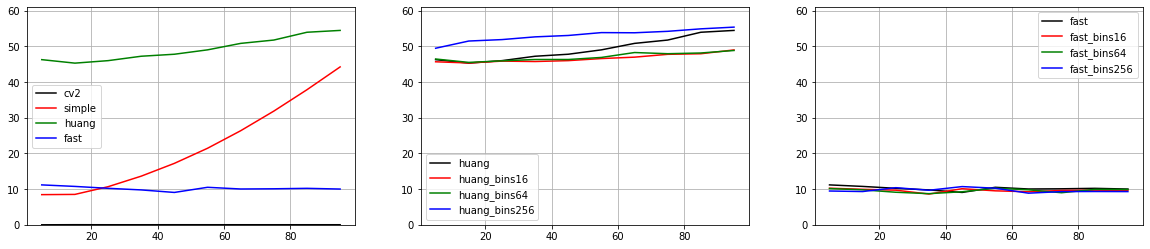

In [12]:
results_512 = set_experiment(cv2.resize(img, (512, 512)))

### Выводы

1. Возможно, моя имплементация алгоритма Huang не самая эффективная, поэтому проигрывает даже алгоритму "в лоб". Однако можно заметить, что на больших значениях `kernel_size` тупой алгоритм по скорости работы приближается к Huang. Т.е. вероятно, асимптотически последний быстрее, но это заметно лишь на на значениях ядра больше 100
2. Алгоритм из OpenCV, очевидно, быстрее, так как сразу написан и оптимизирован на плюсах
3. Быстрый алгоритм безоговорочно обыгрывает остальные самописные. При этом можно заметить, что для него практически не заметна разница при различных значениях числа бинов в гистограмме, что, вероятно, объясняется хорошей векторизируемости алгоритма, где операции для всех значений гистограммы делается одновременно в коде
4. По памяти меньше всего требуется алгоритму "в лоб" - $O(kernel\_size^2)$ дополнительной памяти под медианы
Алгоритм Huang требует дополнительной $O(n\_bins)$ дополнительной памяти на хранение, соответственно, значений гистограммы для текущего окна
Самый быстрый алгоритм требует больше всего - $O(n\_bins \cdot W)$ дополнительной памяти на хранения столбцов гистограм и гистограммы для текущего окна. При желании это можно оптимизировать до $O(n\_bins \cdot min(H, W))$, что будет полезно для случаев с большой разницей координат